In [1]:
###################
#BASIC CLASSES
###################

import matplotlib.pyplot as plt
import random
from random import sample
import pandas as pd
import numpy as np
import math
import os
import openpyxl
from openpyxl.utils.dataframe import dataframe_to_rows
import time


#Item class/blueprint
class item:
    def __init__(self, item_id, item_weight, belongs_to_bin):
        self.item_id = item_id
        self.item_weight = item_weight
        self.belongs_to_bin = belongs_to_bin #which bin_id does it belong to
        
    #Item representation when printing
    def __str__(self):
        return f"Item ID: {self.item_id}, Weight: {self.item_weight}, Belongs to Bin: {self.belongs_to_bin}"
#End class item

#Bin class/blueprint (chromosome)
class bin:
    def __init__(self, bin_id, bin_fitness, items_in_bin=None):
        self.bin_id = bin_id
        self.bin_fitness = bin_fitness
        self.items_in_bin = items_in_bin or []
        
    #Bin representation for printing
    def __str__(self):
        return f"Bin ID: {self.bin_id}, Fitness: {self.bin_fitness}, Items in Bin: {self.items_in_bin}"
#end class bin

#Solution class (collection of bins)
class Solution:
    def __init__(self, bins):
        self.bins = bins  # List of bin objects
        
    def __str__(self):
        result = []
        for idx, bin_ in enumerate(self.bins):
            result.append(f"  Bin ID: {idx}, Fitness: {bin_.bin_fitness}, Items in Bin: {bin_.items_in_bin}")
        return "\n".join(result)
    
    def __len__(self):
        return len(self.bins)

    def __iter__(self):
        return iter(self.bins)

    # You can add more methods as needed for solution-related operations


##################################
#ITEM GENERATION AND BIN PLACEMENT
##################################

#Generate items with different size
def generateItems(num_items_to_generate, bin_capacity):
    items = []
    for i in range(num_items_to_generate):
        items.append(item(i, round(random.uniform(0.0, bin_capacity), 2), None)) #self.item_id = i; self.item_weight = random.uniform(0.0, bin_capacity); self.belongs_to_bin = None;
    return items
#End generateItems

#Place items into empty bin (Initial)
def placeItemsInBins(items, bin_capacity):
    empty_bins = [bin(0, 0)]  # create the first bin
    item_index = 0
    i = 0

    while i < len(empty_bins):
        for j in range(item_index, len(items)):
            if empty_bins[i].bin_fitness + items[j].item_weight < bin_capacity:
                empty_bins[i].items_in_bin.append(items[j].item_id)
                empty_bins[i].bin_fitness += items[j].item_weight
                items[j].belongs_to_bin = empty_bins[i].bin_id  # fix the assignment
                item_index += 1
            elif empty_bins[i].bin_fitness + items[j].item_weight >= bin_capacity:
                empty_bins.append(bin(i + 1, 0))
                i += 1
                break

        if item_index == len(items):
            i += 1

    return Solution(empty_bins)



#Print Items(if you wanna see all items values)
def printItems(items):
    for i in items:
        print(i.item_id, i.item_weight, i.belongs_to_bin)
#End printItems

##############################
#SCORE FITNESS AND MATING POOL
##############################

def calculate_bin_fitness(bin, items):
    """
    Calculate the fitness of a bin based on the sum of item weights.
    """
    bin_fitness = sum(items[item_id].item_weight for item_id in bin.items_in_bin)
    return bin_fitness

def assign_bin_fitness(solution, items):
    """
    Assign fitness to each bin in a solution based on the sum of item weights.
    """
    for bin_ in solution.bins:
        bin_.bin_fitness = calculate_bin_fitness(bin_, items)
        
def calculate_fitness(bins, k, bin_capacity):
    """
    Calculate the fitness of the solution for bin packing problem based on the given formula.
    """
    n = len(bins) # number of bins
    sum_fitness = 0
    for b in bins:
        sum_fitness += (b.bin_fitness / bin_capacity) ** k
    return sum_fitness / n

def sort_solutions_by_fitness(solutions, k, bin_capacity):
    """
    Sort a list of solutions based on their fitness using the calculate_fitness formula.
    """
    return sorted(solutions, key=lambda solution: calculate_fitness(solution.bins, k, bin_capacity), reverse=True)

def sort_and_select_top_percent(solutions, k, bin_capacity, top_percent=25): #Will use to gather experts.
    """
    Sort solutions by fitness and keep only the top percentage.
    """
    sorted_solutions = sort_solutions_by_fitness(solutions, k, bin_capacity)
    top_percent_index = int(len(sorted_solutions) * (top_percent / 100.0))
    top_percent_solutions = sorted_solutions[:top_percent_index]
    return top_percent_solutions


#################
#CROSSOVER
##################
def combine_solutions(solution1, solution2):
    combined_bins = []

    # Append bins from solution1 with updated bin IDs
    for bin1 in solution1.bins:
        combined_bins.append(bin(bin1.bin_id, bin1.bin_fitness, bin1.items_in_bin))

    # Append bins from solution2 with updated bin IDs
    for bin2 in solution2.bins:
        combined_bins.append(bin(bin2.bin_id + len(solution1.bins), bin2.bin_fitness, bin2.items_in_bin))

    return Solution(combined_bins)


import copy
def crossover(parent1, parent2, items):
    # Create a new child solution
    child_bins = []  # Create the first bin

    # Copy the bins from parent1
    temp_sol = copy.deepcopy(combine_solutions(parent1, parent2))

    # Continue with the remaining logic for crossover
    # Iterate until all bins in the temporary solution are empty
    i = 0
    while any(bin_.items_in_bin for bin_ in temp_sol.bins):
        # Find the bin with the highest fitness in the temporary solution
        highest_fitness_bin = max(temp_sol.bins, key=lambda bin_: bin_.bin_fitness)

        # Create a new bin in the child solution with items from the highest fitness bin
        child_bin = bin(i, 0, [])
        child_bin.items_in_bin = list(set(highest_fitness_bin.items_in_bin))  # Use set to ensure uniqueness
        child_bin.bin_fitness = copy.deepcopy(highest_fitness_bin.bin_fitness)
        child_bins.append(child_bin)
        i += 1

        # Remove the items of the highest fitness bin in the temporary solution
        selected_items = set(child_bin.items_in_bin)
        for bin_ in temp_sol.bins:
            bin_.items_in_bin = [item_id for item_id in bin_.items_in_bin if item_id not in selected_items]
            bin_.bin_fitness = sum(items[item_id].item_weight for item_id in bin_.items_in_bin)

        # Remove the bins with no items
        temp_sol.bins = [bin_ for bin_ in temp_sol.bins if bin_.items_in_bin]

    # Assign fitness to bins in the child solution
    assign_bin_fitness(Solution(child_bins), items)

    return Solution(child_bins)



###########
#MUTATIONS
###########

def destroy_and_redistribute(solution, bin_capacity, destruction_percentage):
    # If the input is a Solution object, use its bins attribute; otherwise, assume it's a single bin
    bins = solution.bins if isinstance(solution, Solution) else [solution]

    # Calculate the number of bins to destroy based on the percentage
    num_bins_to_destroy = int(len(bins) * destruction_percentage)
    
    # Randomly select bins to destroy
    bins_to_destroy = random.sample(solution.bins, num_bins_to_destroy)

    # Remove the destroyed bins from the list of bins
    for bin_to_destroy in bins_to_destroy:
        solution.bins.remove(bin_to_destroy)

    # Redistribute the items from the destroyed bins to other bins
    for destroyed_bin in bins_to_destroy:
        for item_id in destroyed_bin.items_in_bin:
            # Find the item in the list with the matching item_id
            matching_item = next(item_obj for item_obj in items if item_obj.item_id == item_id)

            # Try to find a bin to place the item
            placed = False
            for other_bin in solution.bins:
                if other_bin.bin_fitness + matching_item.item_weight <= bin_capacity:
                    other_bin.items_in_bin.append(matching_item.item_id)
                    other_bin.bin_fitness += matching_item.item_weight
                    matching_item.belongs_to_bin = other_bin.bin_id
                    placed = True
                    break

            # If the item couldn't be placed in any existing bin,
            # create a new bin
            if not placed:
                new_bin = bin(len(solution.bins), 0)
                new_bin.items_in_bin.append(matching_item.item_id)
                new_bin.bin_fitness += matching_item.item_weight
                matching_item.belongs_to_bin = new_bin.bin_id
                solution.bins.append(new_bin)

    return solution


#This might not work it seems kinda janky
def item_swap(solution, items, mutation_rate):
    # Perform item swap mutation between two bins with a certain probability (mutation_rate).
    # Modify the bins in place and return the modified set of bins.

    the_bins = [solution] if isinstance(solution, bin) else solution  # Convert a single bin to a list if necessary

    for current_bin in the_bins:
        for item_id in current_bin.items_in_bin:
            if random.random() < mutation_rate:
                # Change item's bin assignment
                item = next(item for item in items if item.item_id == item_id)
                item.belongs_to_bin = None  # Reset the bin assignment

                # Attempt to swap the item with an item from another bin
                other_bin = next((bin_obj for bin_obj in the_bins if bin_obj != current_bin and bin_obj.items_in_bin), None)
                if other_bin is not None:
                    other_item_id = random.choice(other_bin.items_in_bin)
                    other_item = next(item for item in items if item.item_id == other_item_id)

                    # Swap items between the two bins
                    item.belongs_to_bin, other_item.belongs_to_bin = other_bin.bin_id, current_bin.bin_id

    return solution

#########################
#MORE DEFS BEFORE MAIN
#########################



from itertools import combinations
import numpy as np

def create_item_pair_matrix(solutions):
    # Create a set of all unique item pairs
    all_item_pairs = set()
    all_items = set()
    for solution in solutions:
        for bin_ in solution:
            all_item_pairs.update(combinations(bin_.items_in_bin, 2))
            all_items.update(bin_.items_in_bin)


    # Initialize a matrix to store the counts of item pairs
    item_pair_matrix = np.zeros((len(all_items), len(all_items)), dtype=int)


    # Create a mapping from item pairs to matrix indices
    
    pair_to_index = {index: pair for index, pair in enumerate(all_item_pairs)}
    
    # Iterate through each solution and update the matrix
    for solution in solutions:
        for bin_ in solution:
            # Update counts for item pairs in the same bin
            for pair in combinations(bin_.items_in_bin, 2):
                
                index_a =pair[0]
                index_b = pair[1]
                item_pair_matrix[index_a, index_b] += 1
                item_pair_matrix[index_b, index_a] += 1
        
    i,j = np.unravel_index(item_pair_matrix.argmax(), item_pair_matrix.shape)
    most_common_item_pair = []
    most_common_item_pair = [i,j]

    return most_common_item_pair
    

def WOC_sol_placeItemsInBins(items, most_common_pair, bin_capacity):
    empty_bins = [bin(0, 0)]  # create the first bin
    items_del = copy.deepcopy(items)
    empty_bins[0].items_in_bin.append(items[most_common_pair[0]].item_id)
    empty_bins[0].bin_fitness += items[most_common_pair[0]].item_weight
    items[most_common_pair[0]].belongs_to_bin = empty_bins[0].bin_id  # fix the assignment
    
    empty_bins[0].items_in_bin.append(items[most_common_pair[1]].item_id)
    empty_bins[0].bin_fitness += items[most_common_pair[1]].item_weight
    items[most_common_pair[1]].belongs_to_bin = empty_bins[0].bin_id  # fix the assignment
    
    items_del[:] = [item for item in items_del if item.item_id not in most_common_pair]
   

    item_index = 0
    i = 0

    while i < len(empty_bins):
        for j in range(item_index, len(items_del)):
            if empty_bins[i].bin_fitness + items_del[j].item_weight < bin_capacity:
                empty_bins[i].items_in_bin.append(items_del[j].item_id)
                empty_bins[i].bin_fitness += items_del[j].item_weight
                items_del[j].belongs_to_bin = empty_bins[i].bin_id  # fix the assignment
                item_index += 1
            elif empty_bins[i].bin_fitness + items_del[j].item_weight >= bin_capacity:
                empty_bins.append(bin(i + 1, 0))
                i += 1
                break

        if item_index == len(items_del):
            i += 1

    return Solution(empty_bins)
#Creates Our initial Population
def initial_pop(population_size, items, bin_capacity):
    population = []
    population.append(placeItemsInBins(items, bin_capacity))
    for i in range(population_size-1):
        population.append(copy.deepcopy(population[0])) #Filling the empty bin (Initialize the chromosome)
        
    return population

def bin_lower_bound(items, bin_capacity):
    total_weight = 0
    for item_obj in items:
        total_weight += item_obj.item_weight
    theoretical_best = total_weight/bin_capacity
    print("The Minimum number of Possible Bins:", theoretical_best)
    return theoretical_best

def muatation_pop(solutions, items, bin_capacity, mutation_rate):
    updated_population = []
    for solution in solutions:
        # Apply destroy_and_redistribute with 50% probability
        if random.random() < mutation_rate:
            destroy_and_redistribute(solution, bin_capacity, mutation_rate)

        # Apply item_swap with 50% probability
        if random.random() < mutation_rate:
            item_swap(solution, items, mutation_rate)

        # Append the modified solution to the updated population
        updated_population.append(solution)
    return updated_population

def breed_pop(cur_pop, mating_pool, items, bin_capacity):
    for solution in mating_pool:
        # Select three other solutions randomly from the mating pool
        other_solutions = random.sample(mating_pool, 3)

        # Apply crossover with the selected solutions
        for other_solution in other_solutions:
            children = crossover(solution, other_solution, items)
            cur_pop.append(children)
    return cur_pop


#calculate_fitness(bins, k, bin_capacity)
def average(solutions, bin_capacity, k):
    averages = []
    df4 = []
    size = len(solutions)
    for i in range(len(solutions)):
        averages.append(calculate_fitness(solutions[i], k, bin_capacity))
    df = pd.DataFrame(np.array(averages), columns= ["Fitness"])
    df2 = df["Fitness"].std()
    df3 = df["Fitness"].mean()
    df4.append(df2)
    df4.append(df3)
    return df4

In [12]:
run = str(5)
graph_file_path = '~/Documents/final_data_collection/run7/'+run+'_'
graph_file_path = os.path.expanduser(graph_file_path)
print(run)

def gen_vs_bins(bin_progress, method, generations): #progress and average_progress are lists created in the main GA function
    graph_title = "Generations vs # of Bins graph of the " + method + " over " +str(generations) + " generations"
    plt.title(graph_title)
    plt.plot(bin_progress, label= 'Best')
    #plt.plot(average_progress, label= 'Average')
    plt.ylabel('Number of Bins')
    plt.xlabel('Generation')
    plt.legend()
    plt.savefig(graph_file_path+ method+'_gen_vs_bin.png', bbox_inches='tight', facecolor='white')

    plt.show()

    
def gen_vs_std(standard_deviation, method, generations):
    graph_title = "Generations vs Standard Deviation graph of the " + method + " over " +str(generations) + " generations"
    plt.title(graph_title)
    plt.plot(standard_deviation, label='Standard Deviation')
    plt.ylabel('Distance')
    plt.xlabel('Generation')
    plt.legend()
    plt.show()

def find_average_of_pop(scored_pop): #This function finds the average fitness of the given population
    df = pd.DataFrame(np.array(np.array(scored_pop)), columns= ["Index", "Fitness"])
    df2 = df["Fitness"].mean()
    return df2

def find_std(scored_pop):
    df = pd.DataFrame(np.array(np.array(scored_pop)), columns= ["Index", "Fitness"])
    df3 = df["Fitness"].std()
    return df3

def gen_vs_fitness_graph(progress, average_progress, method, generations): #progress and average_progress are lists created in the main GA function
    graph_title = "Generations vs Fitness graph of the " + method + " over " +str(generations) + " generations"
    plt.title(graph_title)
    plt.plot(progress, label= 'Best')
    plt.plot(average_progress, label= 'Average')
    plt.ylabel('Fitness')
    plt.xlabel('Generation')
    plt.legend()
    plt.savefig(graph_file_path+ method+'_gen_vs_fitness', bbox_inches='tight', facecolor='white')
    plt.show()

def plot_GA_vs_WOC(method_1_progress, method_2_progress, progressType,  method_1, method_2, generations):
    graph_title = "Generations vs "+progressType+ " graph of the " + method_1 + " and " + method_2 + " over " +str(generations) + " generations"
    plt.title(graph_title)
    plt.plot(method_1_progress, label= method_1)
    plt.plot(method_2_progress, label= method_2)
    plt.ylabel('# of Bins')
    plt.xlabel('Generation')
    plt.legend()
    plt.savefig(graph_file_path+'_GA_vs_WOC.png', bbox_inches='tight', facecolor='white')
    plt.show()



def gen_dataframe(run, generation_count, pop_size, mutation_rate, i_a_fitness, GA_average_fitness, WOC_average_fitness, initial_bins, lower_bound, i_GA_best_fitness,i_WOC_best_fitness, GA_best_fitness, WOC_best_fitness, number_of_items, k, bin_capacity, GA_number_of_bins, WOC_number_of_bins, i_std, GA_std, WOC_std): #Creates a dataframe of the following values. 
    data_ = {}
    #GA_number_of_bins = len(GA_best_sol)
    #WOC_number_of_bins = len(WOC_best_sol)
    data_ = {'Run': [run],
            'Generations': [generation_count],
            'Initial Population Size': [pop_size],
            'Mutation Rate': [mutation_rate],
            'Initial Average Fitness': [i_a_fitness],
             'Initial Standard Deviation': [i_std],
            'Initial # of Bins': [initial_bins],
             'Lower Bound # of Bins': [lower_bound],
             'Initial Basic GA Best Fitness': [i_GA_best_fitness],
            'Basic GA Best Fitness': [GA_best_fitness],
            'Basic GA Average Fitness': [GA_average_fitness],
             'Basic GA Standard Deviation': [GA_std],
            'Basic GA # of Bins': [GA_number_of_bins],
            'Initial WOC GA Best Fitness': [i_WOC_best_fitness],
            'WOC GA Best Fitness': [WOC_best_fitness],
            'WOC GA Average Fitness': [WOC_average_fitness],
             'WOC GA Standard Deviation': [WOC_std],
            'WOC GA # of Bins': [WOC_number_of_bins],
            '# of Items': [number_of_items],
            'k Value': [k],
            'Bin Capacity': [bin_capacity]}
    df = pd.DataFrame(data_).T
    return df


def data_to_excel(df): #Takes a dataframe and insert it into an excel file. It will not overwrite data in an already existing file. 
    file = r'~/Documents/final_data_collection/run7/apple.xlsx'

    # create excel file
    if os.path.isfile(file):  # if file already exists append to existing file
        workbook = openpyxl.load_workbook(file)  # load workbook if already exists
        sheet = workbook['Sheet 1']  # declare the active sheet 
        
        max_column = sheet.max_column + 1 if sheet.max_column else 1

        # Write the DataFrame column by column
        for col_num, (col_name, data) in enumerate(df.items(), start=max_column):
            header_cell = sheet.cell(row=1, column=col_num, value=col_name)
            for row_num, value in enumerate(data, start=2):
                sheet.cell(row=row_num, column=col_num, value=value)

        workbook.save(file)
        workbook.close()
        
        #df_reset = df.reset_index()
    # append the dataframe results to the current excel file
        #for row in dataframe_to_rows(df, header = False, index = False):
            #sheet.append(row)
        #workbook.save(file)  # save workbook
        #workbook.close()  # close workbook
    else:  # create the excel file if doesn't already exist
        with pd.ExcelWriter(path = file, engine = 'openpyxl') as writer:
            df.to_excel(writer, index = True, sheet_name = 'Sheet 1')


5


The Minimum number of Possible Bins: 505.3007999999994


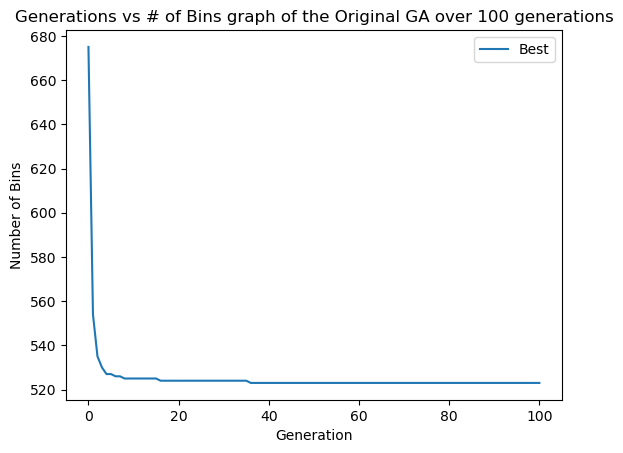

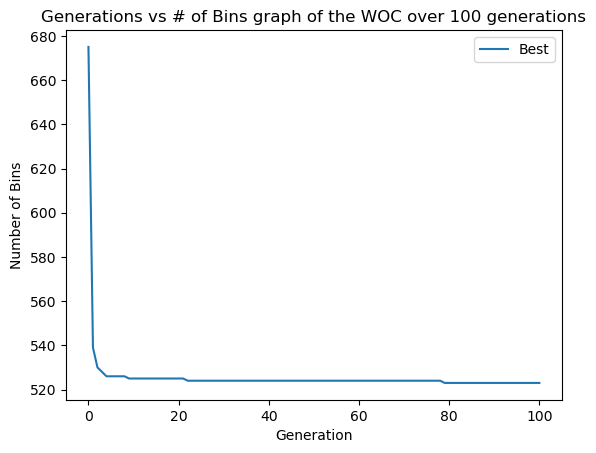

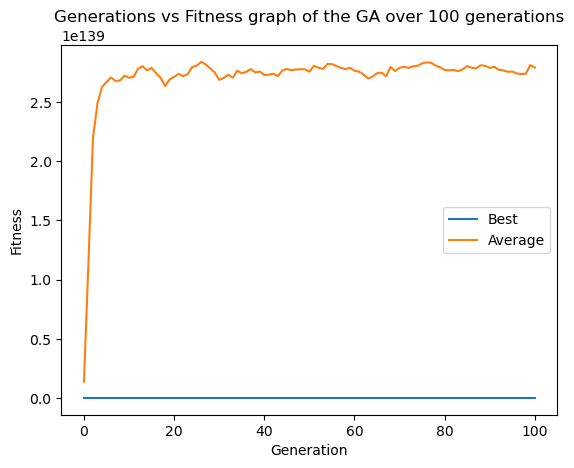

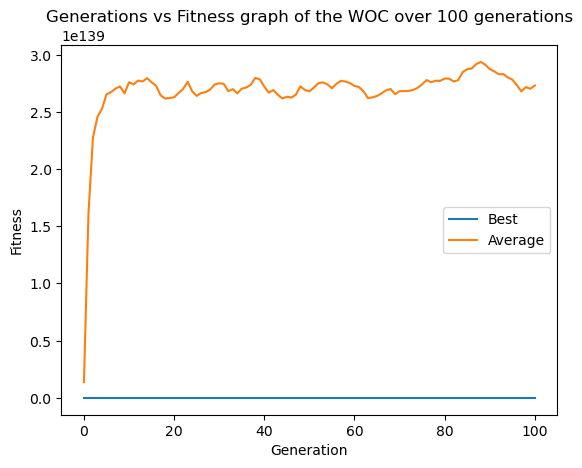

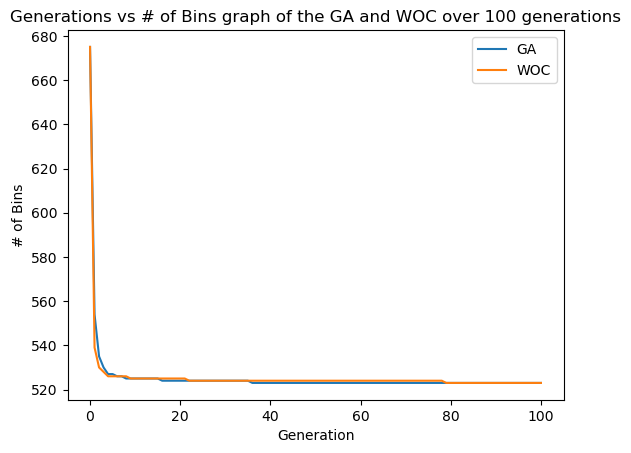

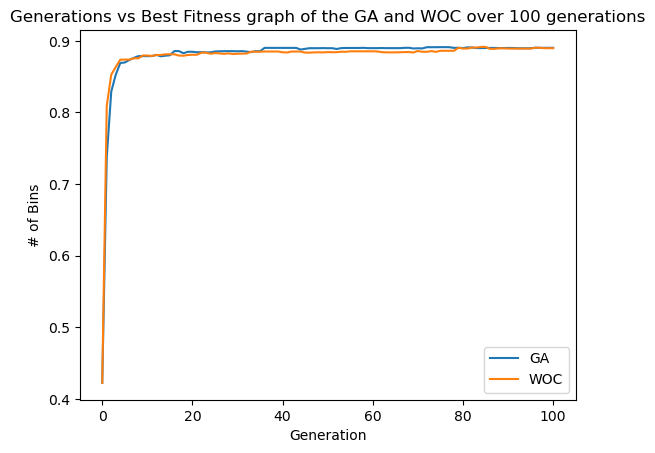

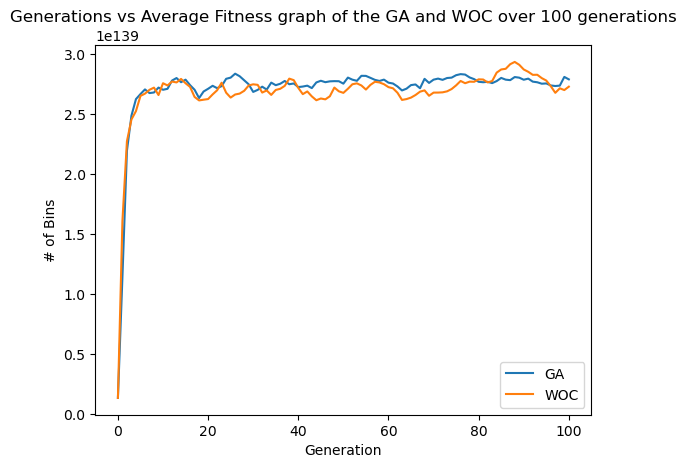

,0
Run,5
Generations,100
Initial Population Size,100
Mutation Rate,0.5
Initial Average Fitness,1374407877721068452126723904955222624986427134...
Initial Standard Deviation,3321931233185066746415778590827584046923008032...
Initial # of Bins,675
Lower Bound # of Bins,506
Initial Basic GA Best Fitness,0.422
Basic GA Best Fitness,0.89


3350.034346818924
The Minimum number of Possible Bins: 505.3007999999994


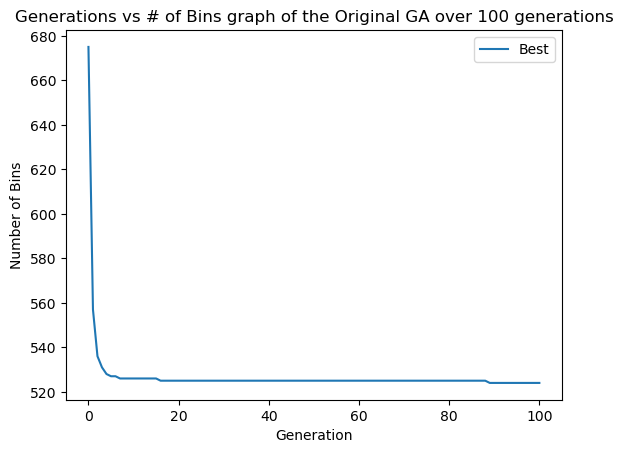

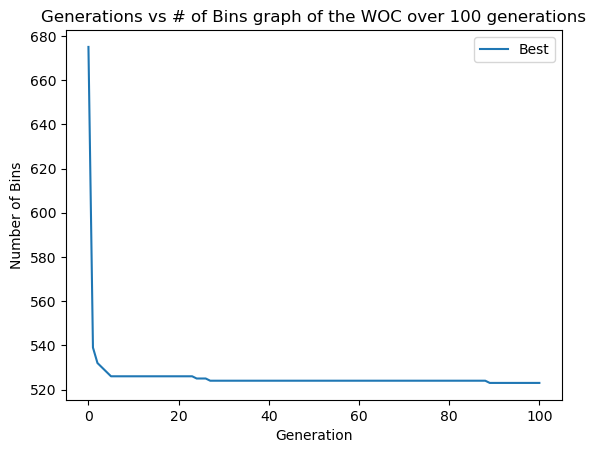

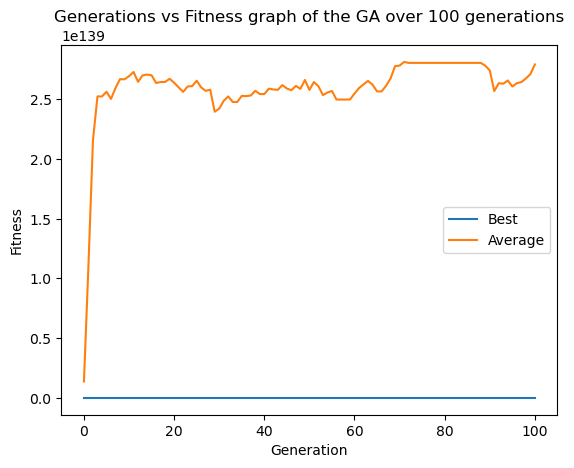

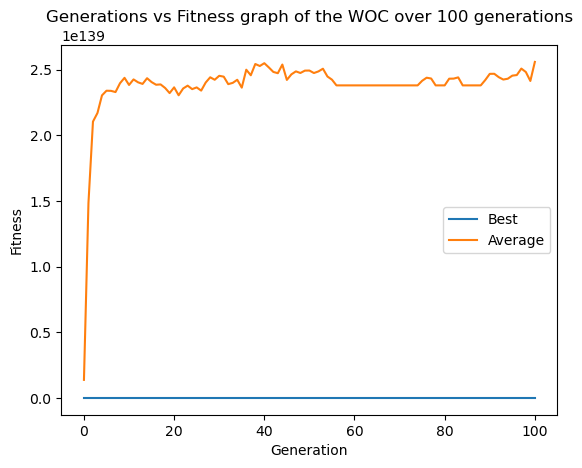

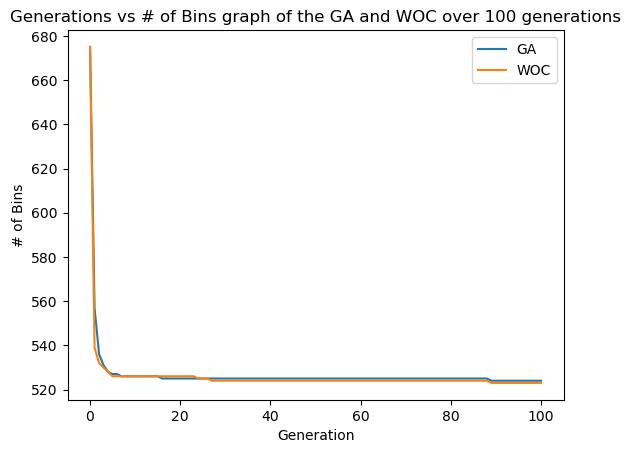

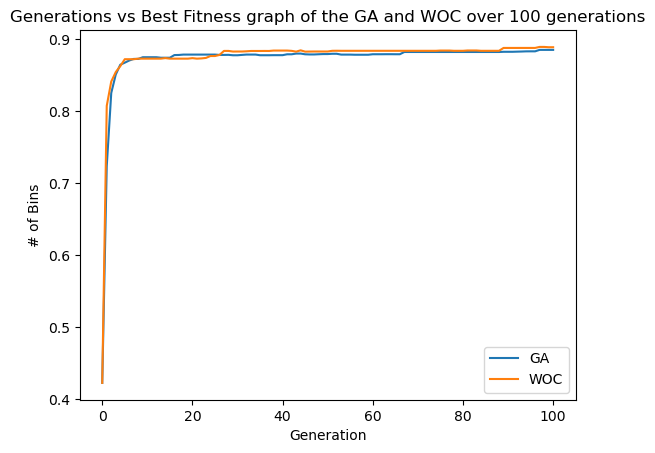

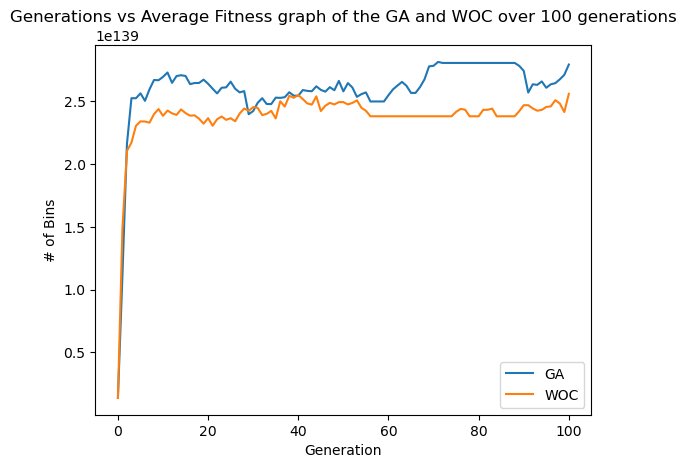

,0
Run,5
Generations,100
Initial Population Size,20
Mutation Rate,0.5
Initial Average Fitness,1374407877721068782654708300079522100944081150...
Initial Standard Deviation,3391145567477371180960990882109145989428619802...
Initial # of Bins,675
Lower Bound # of Bins,506
Initial Basic GA Best Fitness,0.422
Basic GA Best Fitness,0.885


636.0037705898285


In [13]:
items = generateItems(1000, 100.0) #holds array of item objects (class item)

def GA_next_gen(current_population, items, bin_capacity, mutation_rate):
    #mutation
    current_population = muatation_pop(current_population, items, bin_capacity, mutation_rate)

    #breeding
    mating_pool = sort_and_select_top_percent(current_population, 2, bin_capacity)
    current_population = copy.deepcopy(mating_pool)
    current_population = breed_pop(current_population, mating_pool, items, bin_capacity)
    return current_population

def WOC_GA_next_gen(WOC_current_population, items, bin_capacity, mutation_rate):
    #mutation
    WOC_current_population = muatation_pop(WOC_current_population, items, bin_capacity, mutation_rate)

    #breeding
    mating_pool = sort_and_select_top_percent(WOC_current_population, 2, bin_capacity)
    WOC_current_population = copy.deepcopy(mating_pool)
    WOC_current_population = breed_pop(WOC_current_population, mating_pool, items, bin_capacity)
    WOC_sols = []
    item_pair_matrix = create_item_pair_matrix(sort_and_select_top_percent(WOC_current_population, 2, bin_capacity))
    new_sol = WOC_sol_placeItemsInBins(items, item_pair_matrix, bin_capacity)
    WOC_current_population.append(new_sol)
    
    return WOC_current_population


def GA(generations, population_size, mutation_rate, item_count, bin_capacity, k):
    lower_bound = math.ceil(bin_lower_bound(items, bin_capacity))

    GA_bins_progress = []
    GA_fitness_progress = []
    GA_average_fitness_progress =[]
    GA_std_progress = []
    WOC_bins_progress = []
    WOC_fitness_progress = []
    WOC_average_fitness_progress =[]
    WOC_std_progress =[]

    population = initial_pop(population_size, items, bin_capacity)
    current_population = population
    WOC_current_population = population.copy()

    #print(len(sort_and_select_top_percent(current_population, 2, bin_capacity)[0].bins))
    #print(len(sort_and_select_top_percent(WOC_current_population, 2, bin_capacity)[0].bins))

    GA_sort_sel = sort_and_select_top_percent(current_population, k, bin_capacity)
    WOC_sort_sel = sort_and_select_top_percent(WOC_current_population, k, bin_capacity)
    GA_bins_progress.append(len(GA_sort_sel[0].bins))
    WOC_bins_progress.append(len(WOC_sort_sel[0].bins))

    GA_fitness_progress.append(calculate_fitness(GA_sort_sel[0], k, bin_capacity))
    WOC_fitness_progress.append(calculate_fitness(WOC_sort_sel[0], k, bin_capacity))

    GA_average_fitness_progress.append(average(current_population, k, bin_capacity)[1])
    WOC_average_fitness_progress.append(average(WOC_current_population, k, bin_capacity)[1])

    GA_std_progress.append(average(current_population, k, bin_capacity)[0])
    WOC_std_progress.append(average(WOC_current_population, k, bin_capacity)[0])

    for i in range(0, generations):
        current_population = GA_next_gen(current_population, items, bin_capacity, mutation_rate)
        WOC_current_population = WOC_GA_next_gen(WOC_current_population, items, bin_capacity, mutation_rate)
       
        GA_sort_sel = sort_and_select_top_percent(current_population, k, bin_capacity)
        WOC_sort_sel = sort_and_select_top_percent(WOC_current_population, k, bin_capacity)

        GA_bins_progress.append(len(GA_sort_sel[0].bins))
        WOC_bins_progress.append(len(WOC_sort_sel[0].bins))

        GA_fitness_progress.append(calculate_fitness(GA_sort_sel[0], k, bin_capacity))
        WOC_fitness_progress.append(calculate_fitness(WOC_sort_sel[0], k, bin_capacity))

        GA_average_fitness_progress.append(average(current_population, k, bin_capacity)[1])
        WOC_average_fitness_progress.append(average(WOC_current_population, k, bin_capacity)[1])
        
        GA_std_progress.append(average(current_population, k, bin_capacity)[0])
        WOC_std_progress.append(average(WOC_current_population, k, bin_capacity)[0])
        
        #print(calculate_fitness(GA_sort_sel[0], k, bin_capacity))
        #print(GA_sort_sel[0])
    
        #print("Original GA:", len(sort_and_select_top_percent(current_population, 2, bin_capacity)[0].bins))
        #print("WOC GA:", len(sort_and_select_top_percent(WOC_current_population, 2, bin_capacity)[0].bins))

    
    #gen_vs_bins(bins_progress, "GA+Mutation", generations)
    progressType1 = "# of Bins"
    progressType2 = "Best Fitness"
    progressType3 = "Average Fitness"
    gen_vs_bins(GA_bins_progress, "Original GA", generations)
    gen_vs_bins(WOC_bins_progress, "WOC", generations)
    gen_vs_fitness_graph(GA_fitness_progress,GA_average_fitness_progress, "GA", generations)
    gen_vs_fitness_graph(WOC_fitness_progress, WOC_average_fitness_progress, "WOC", generations)
    plot_GA_vs_WOC(GA_bins_progress, WOC_bins_progress, progressType1, "GA", "WOC", generations)
    plot_GA_vs_WOC(GA_fitness_progress, WOC_fitness_progress, progressType2, "GA", "WOC", generations)
    plot_GA_vs_WOC(GA_average_fitness_progress, WOC_average_fitness_progress, progressType3, "GA", "WOC", generations)

    
    #_data = gen_dataframe(run, generations, population_size, GA_bins_progress[0], lower_bound, GA_fitness_progress[0],WOC_fitness_progress[0], GA_fitness_progress[-1], WOC_fitness_progress[-1],len(items),k,bin_capacity,GA_bins_progress[-1], WOC_bins_progress[-1])
    _data = gen_dataframe(run, generations, population_size, mutation_rate, GA_average_fitness_progress[0], GA_average_fitness_progress[-1], WOC_average_fitness_progress[-1],  GA_bins_progress[0], lower_bound, GA_fitness_progress[0],WOC_fitness_progress[0], GA_fitness_progress[-1], WOC_fitness_progress[-1],len(items),k,bin_capacity,GA_bins_progress[-1], WOC_bins_progress[-1], GA_std_progress[0], GA_std_progress[-1], WOC_std_progress[-1])
    with pd.option_context('display.max_rows', None,
                       'display.max_columns', None,
                       'display.precision', 3,):
        
    
        display(_data)

        data_to_excel(_data)
   

#start = time.time()
#GA(generations=30, population_size=50, mutation_rate=0.5, item_count= 200, bin_capacity= 30.0, k=4)
#end = time.time()
#delta = end - start
#print(delta)

#start = time.time()
#GA(generations=500, population_size=100, mutation_rate=0.5, item_count= 100, bin_capacity= 10.0, k=4)
#end = time.time()
#delta = end - start
#print(delta)

#start = time.time()
#GA(generations=10, population_size=100, mutation_rate=0.5,item_count= 100, bin_capacity= 10.0, k=4)
#end = time.time()
#delta = end - start
#print(delta)

#start = time.time()
#GA(generations=100, population_size=100, mutation_rate=0.5,item_count= 200, bin_capacity= 30.0, k=4)
#end = time.time()
#delta = end - start
#print(delta)

#start = time.time()
#GA(generations=100, population_size=100,mutation_rate=0.5, item_count= 400, bin_capacity= 30.0, k=4)
#end = time.time()
#delta = end - start
#print(delta)

start = time.time()
GA(generations=100, population_size=100,mutation_rate=0.5, item_count= 400, bin_capacity= 100.0, k=4)
end = time.time()
delta = end - start
print(delta)

start = time.time()
GA(generations=100, population_size=20, mutation_rate=0.5,item_count= 1000, bin_capacity= 100.0, k=4)
end = time.time()
delta = end - start
print(delta)
